## Chnage points

Change points are abrupt changes in the time series data.
- Usually, change points are described in terms of changes between segments. To put it simple, a change point divides a time series into two segments where each segment has its own statistical characteristics (e.g., mean, variance, etc.). Thus, the change point is located where the underlying characteristics change abruptly.

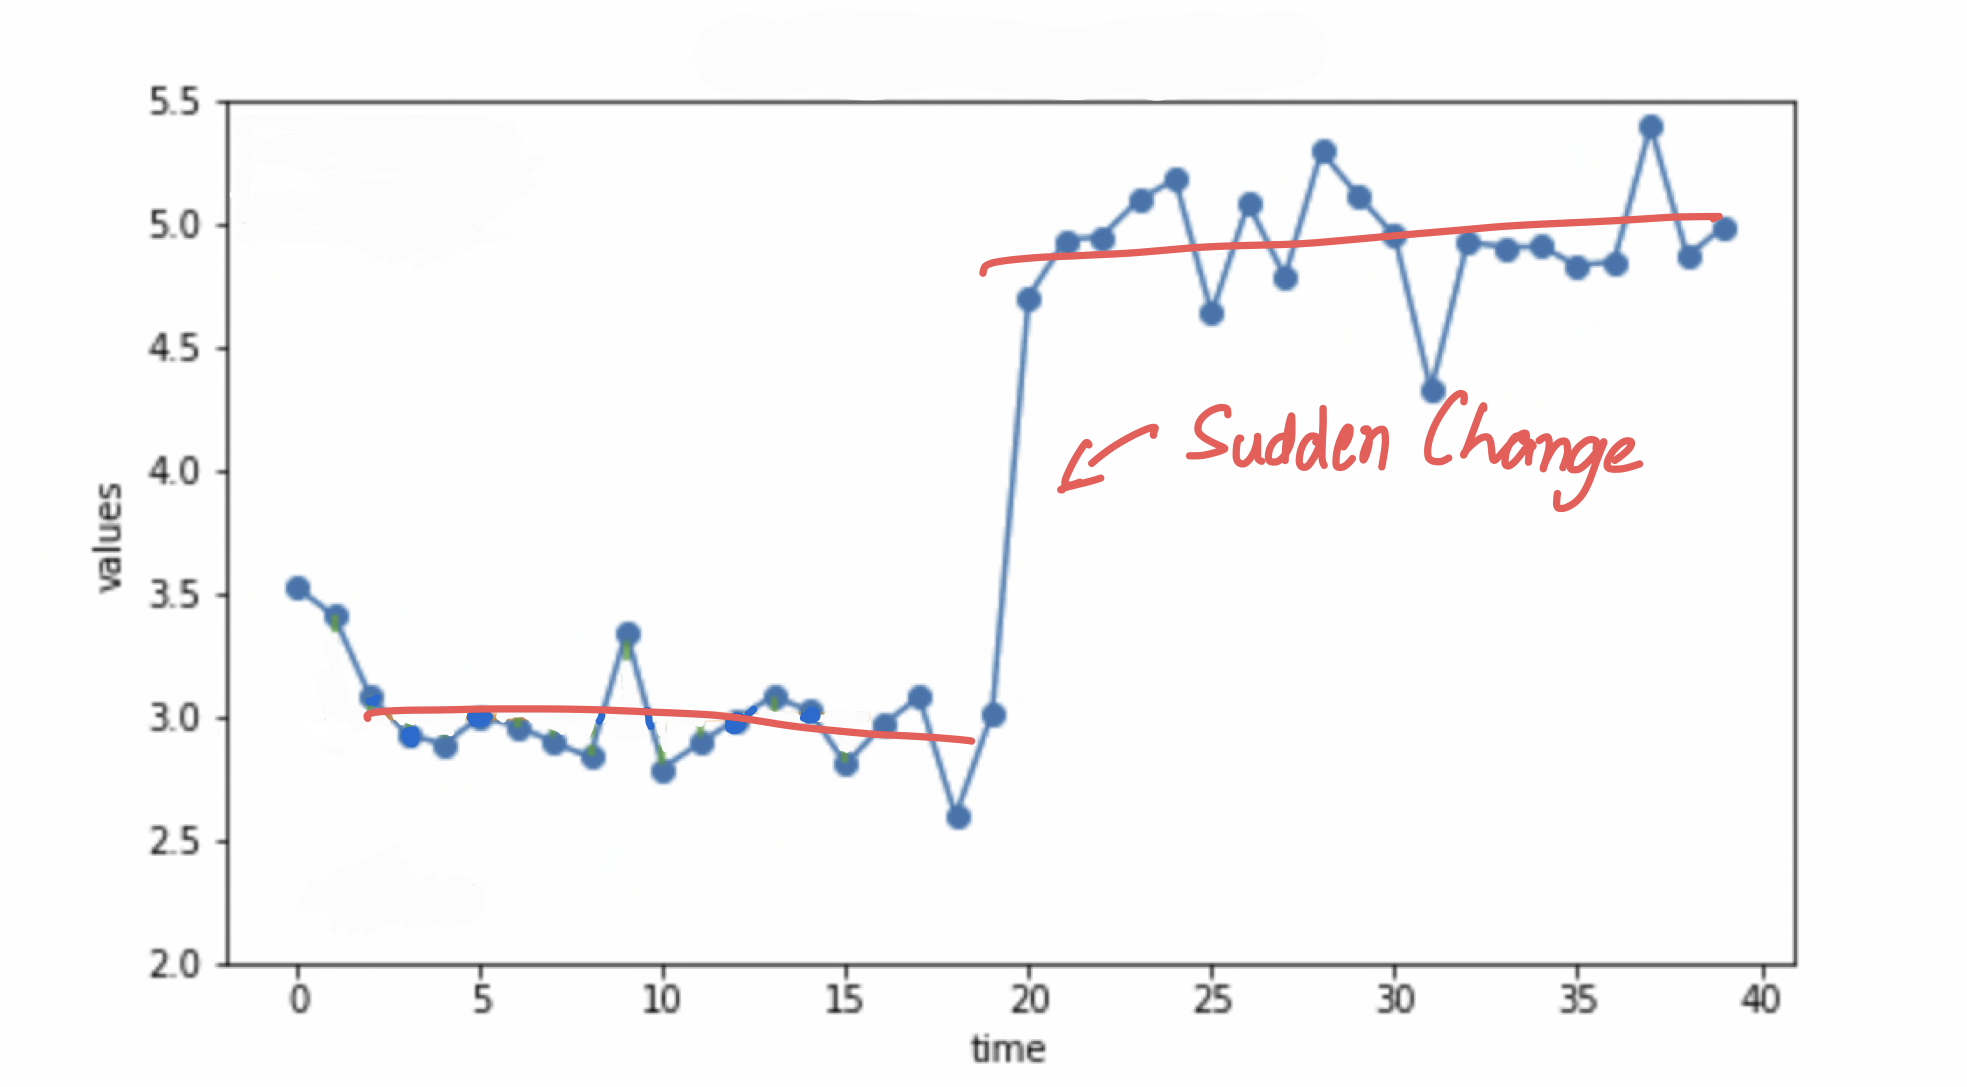

There are countless ways and methods for detecting change points that have been developed during the last decades.

There are many methods to detect them, with various human inputs. For getting some intuition, lets discuss a very simple algorithm that uses a Sliding Window

- Walk through the series with a window of fixed size
- For each step, compute a cost of all elements in the window. There are many options for this cost funtion.
- Wherever the cost locally peaks, the center of the window can be considered as a changepoint.
- We can add other conditions of threshold cost, etc to avaoid making too many detections.

In [ ]:
from IPython.display import Image
Image(url='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/752/original/illustration_of_change_point_detectopn_via_sliding-window.gif?1658421673')

in the illustration above
- the standard deviation was low till time ~18
- it increased suddenly till time ~22
- it again gets to a very low value

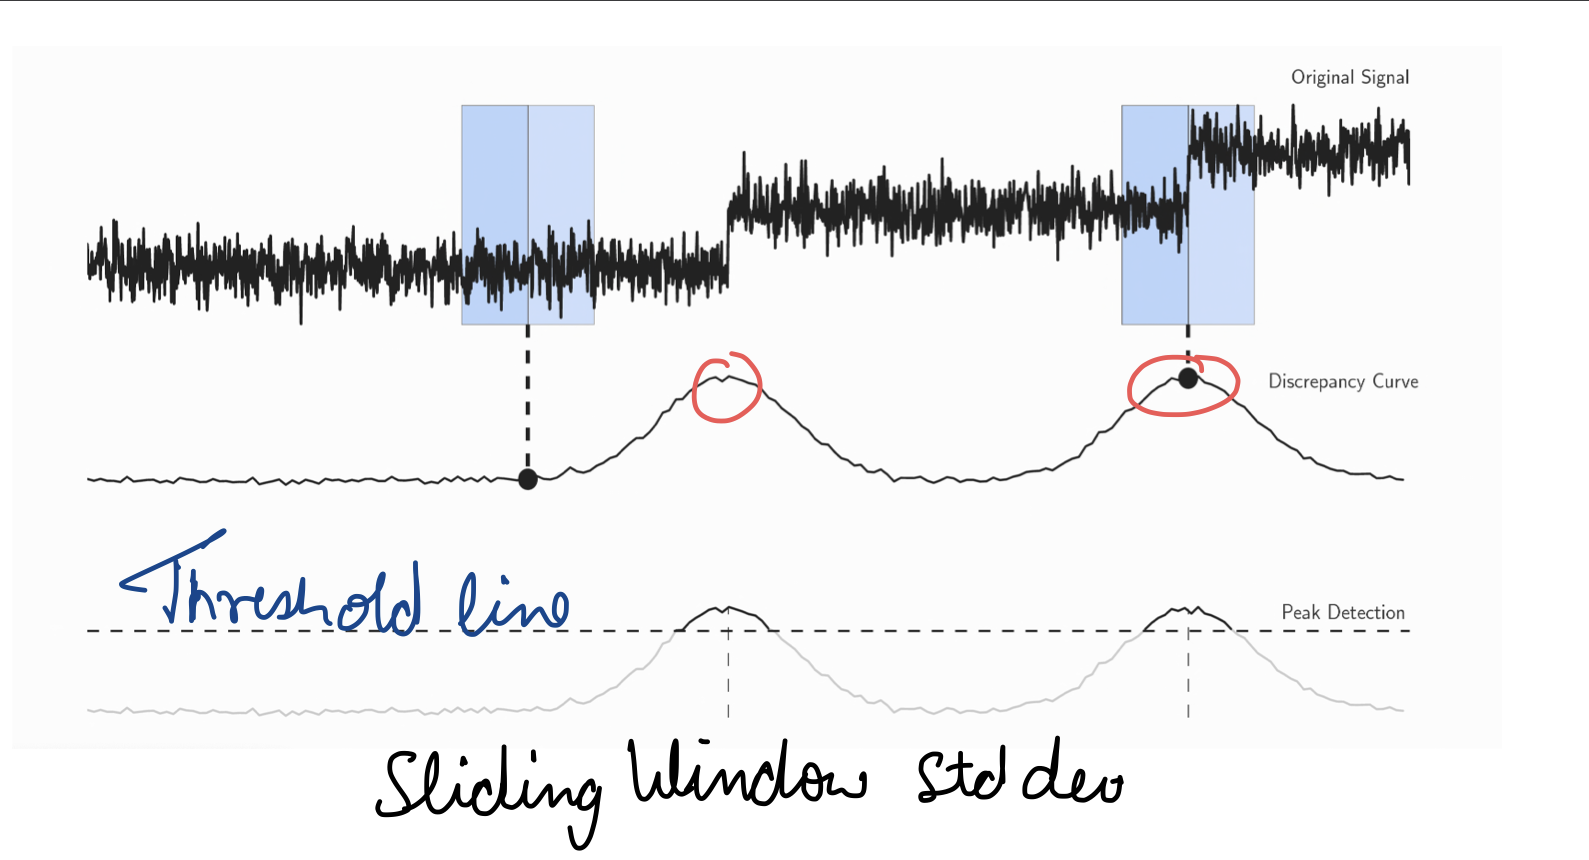

#### **What are the other factors, based on which one can identify a change point?**


As we saw above for standart deviation we can also use different other metrics to get the same result based on the data and situation


Collage of change points based on different factors
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/406/original/CHANGE_POINT.png?1659598744">


# Imagine you are a Data Scientist at a food chain ‘Xotica’!

Your manager has asked you to forecast the number of visitors for upcoming 39 days (almost 6 weeks) using the number of visitors recorded within the past 1-1.5 years.


Reading the data

In [ ]:
!gdown 1PYs1HQg9gQAtELrptBPD9x6SWP3vvrre

Downloading...
From: https://drive.google.com/uc?id=1PYs1HQg9gQAtELrptBPD9x6SWP3vvrre
To: /content/rest_vis.csv
100% 13.1k/13.1k [00:00<00:00, 16.1MB/s]


In [ ]:
df = pd.read_csv('/content/rest_vis.csv')
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [ ]:
df.shape

(517, 4)


The provided dataset has features `‘Date’, ‘holiday’, 'weekday' and 'total`(total no. of visitors).

The data consists of number of **daily** visitors to the restaurant located in the United States, subject to American holidays.

The data set contains 517 days: 478 days of restaurant's data and 39 days of data which have `Nan` in `total`.

Let's find out the number of rows having values 'Nan' in dataset.

In [ ]:
df.isna().sum()

date        0
weekday     0
holiday     0
total      39
dtype: int64

Here let's keep a copy of the original data so that in future, even after modifications on the data we won't have to read the csv again and again.

In [ ]:
df1 = df.copy()

Let's drop all the rows which have `Nan`.

In [ ]:
df.dropna(inplace = True)

Set the `date` column as index after converting it to datetime format.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head(5)

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


**NOTE:-**
- Here you can see, that the target variable of the time series is the ```total``` column.
- In our last business case, we saw only date and the target variable.
- However, there are other columns: ```holiday, weekday```.

<br>





#### Plot the source data.

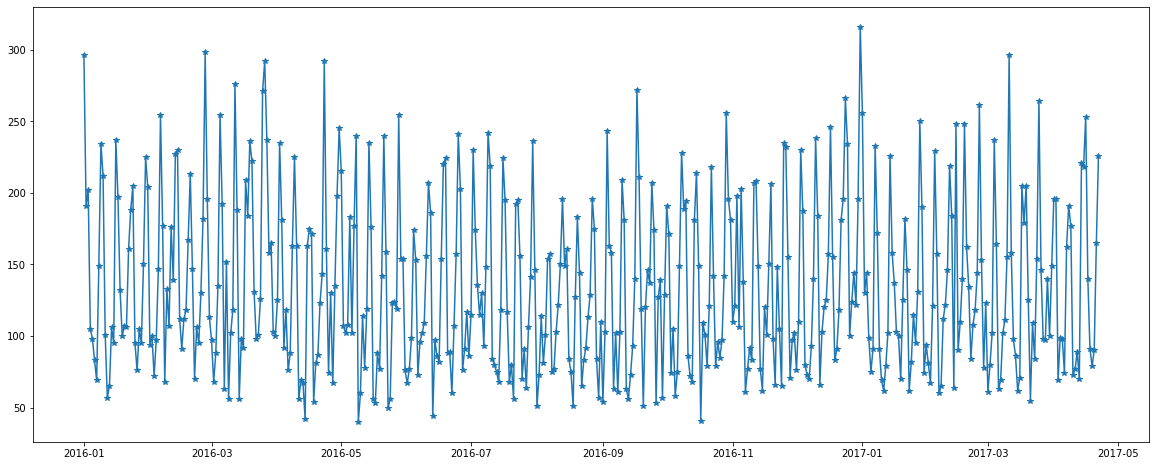

In [ ]:
# Lets take a look at our time series plot
plt.plot(df.index, df['total'], '-*')
plt.show()

> **INTERACTION**
> - Can you guess which days of the week can the peaks in the data represent?
> - Ans: weekends

In the above plot, we can see the peaks but we can't map those peaks to any particular days. Therefore let's try to decrease the number of days to plot, so that we get more insights.

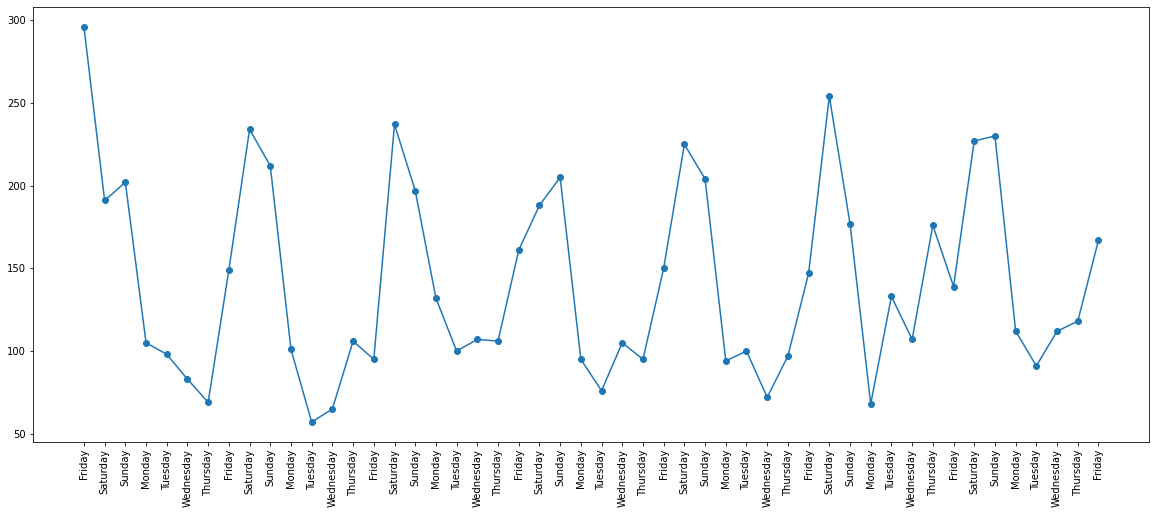

In [ ]:
plt.plot(range(50),df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50],rotation = 90)
plt.show()

It is easily observable that the peaks in the number of visitors is around Saturday and Sunday.

#### Plot the data with holidays.

We also have the data about `holidays`, therefore let's visualize it to observe any relationship between holidays and number of people visiting if it exists.

In [ ]:
df['holiday'].value_counts()

0    446
1     32
Name: holiday, dtype: int64

feature `holiday` is representing whether there is holiday (1) on the day or not(0).

Plot of data with `holiday`. Lets use a red line to indicate that the given day is a holiday.

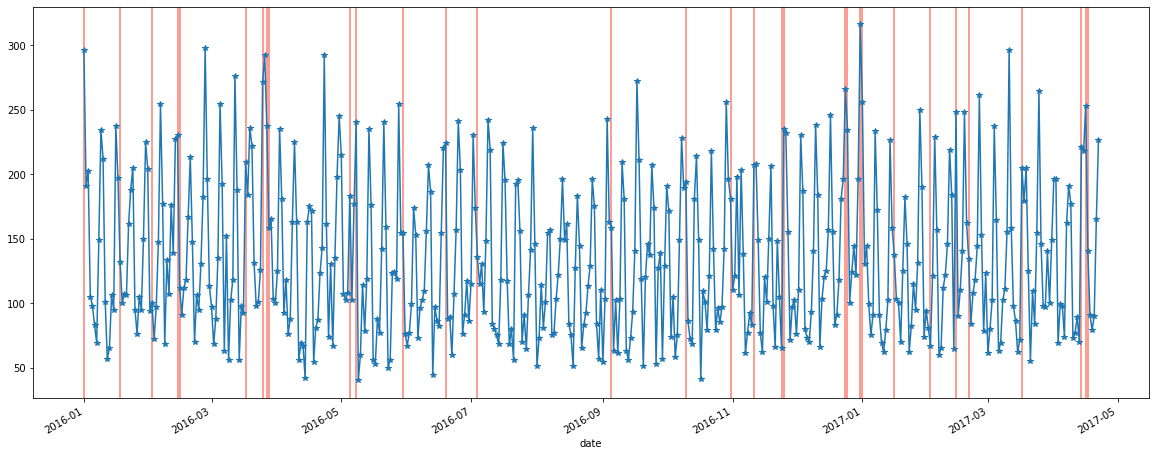

In [ ]:
# Lets take a look at our time series plot
holidays = df.loc[df.holiday==1].index
for hday in holidays:
    plt.axvline(x=hday, color='#FA8072')
df.total.plot(style='-*')
plt.show()

**Notice:-**
- We can see that holidays generally see a **peak** in foot falls.

**Now let's try to decompose the time series to see if it follows any pattern**

<Figure size 1440x576 with 0 Axes>

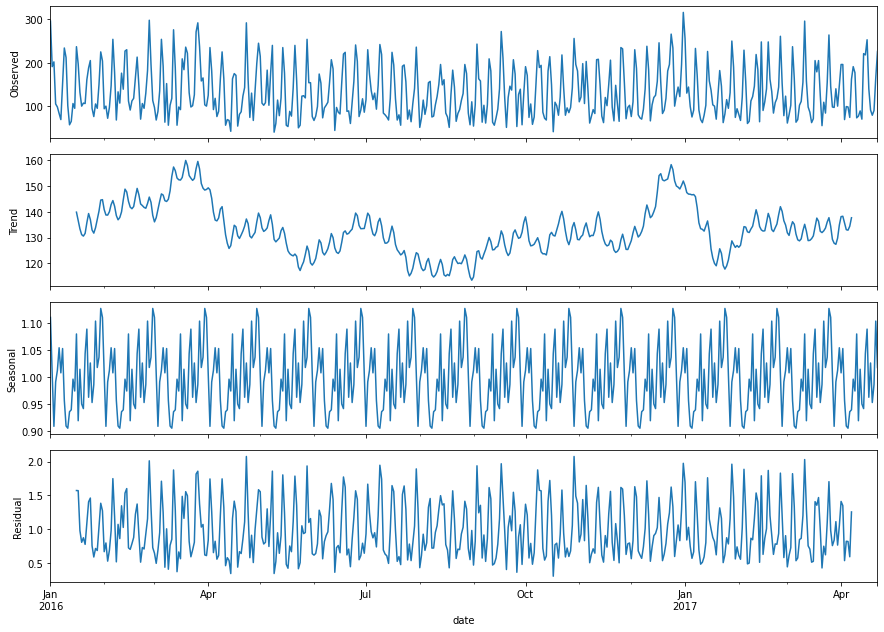

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['total'], model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 9)
fig.show()

* From the above decomposition, it's visible that the data consists of seasonality and the trend is increasing and decreasing which is understandable as the number of visitors will increase during the weekends.

* As their is seasonality, let's try to use SARIMA for the predictions.

### Lets generate a baseline forecast

Now we will fit a **SARIMA model** of seasonal order (1,0,1,7) on the training data.


Here,
- $P=1$: Seasonal Auto regressive order.
- $D=0$: Differencing order of the seasonal process.
- $Q=1$: Seasonal moving average order.
- $s=7$: periodicity where the pattern repeat itself (length of cycle).
 - We can observe a **weekly** pattern, hence 7
- $p,d,q$: AR order, MA order and the Differencing order respectively, have been kept default (1,0,0)

<br>


> **Though not compulsary, a Few guidelines that one should keep in mind:**
- $m$: seasonality
 - We can identify this from the ACF and PACF plot where our value m is equal to the lag with the greatest autocorrelation coefficient other than that at lag=0.
- $P, Q$: Seasonal AR and MA orders
 - We generally do not want P+Q to exceed 2.
 - Using increasingly complex models will increase the risk of **overfitting**.
- $D$: Seasonal Differencing order
 - This can be found using `Adfuller test` on the seasonal decompose.
 - The rule of thumb for our D parameter is that both `D` and the series differencing order `d` should not be greater than 2.



Let's split the data into train and test.


In [ ]:
train = df.iloc[:436]
test = df.iloc[436:]

In [ ]:
test.tail()

,weekday,holiday,total
date,,,
2017-04-18,Tuesday,0,91.0
2017-04-19,Wednesday,0,79.0
2017-04-20,Thursday,0,90.0
2017-04-21,Friday,0,165.0
2017-04-22,Saturday,0,226.0


Let's train a pure seasonality based model, by ignoring the `p, d, q` hyperparamters

In [ ]:
model = SARIMAX(train['total'],seasonal_order=(1,0,1,7))
results = model.fit()
fc = results.forecast(42)

###Model Diagnostics
Four plots result from the plot_diagnostics function. The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram.Let's analyze the residuals after training the model on the SARIMA

- **Standardized residual**
There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

- **Histogram plus KDE estimate**
The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

- **Normal Q-Q**
Most of the data points should lie on the straight line

- **Correlogram (ACF plot)**
95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

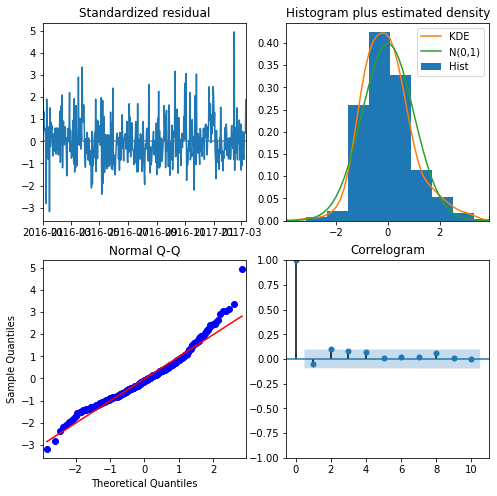

In [ ]:
results.plot_diagnostics(figsize=(8,8));

> **By observing the residual plots, what can we infer about the patterns in the residuals?**

- The residuals have **constant variance**.
- Majority of the dots lie on the red line in the Normal Q-Q plot
 - Hence, the residuals follow a **normal distribution.**
- The residuals are **not auto correlated** as there is no significant pattern.


  

Now let's use the predict() function to get the predictions for the observations in the test data.

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end)

#### Observing the relation of predicted vs actual values on holidays

Let's plot the predicted forecasts and the actual observed values on the test set, and calculate performance scores.

Also, let's add a red line to indicate the **holidays** in the test set.

**Instructor Note:**
> - No need to run the cell as the plot will be same as the attached image but arrows will not be there.

In [ ]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'
ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5)

MAE : 25.159<br>
RMSE : 31.97<br>
MAPE: 0.202<br>
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/768/original/Screenshot_2022-07-22_at_10.41.50_AM.png?1658466294" width="800" height="400">

> **Q. Can you observe any difference between actual and predicted values on the days when there was a holiday?**

 If we look at the plot of total vs predictions, it can be observed that the model has missed peaks for the holidays (see the arrows).

# Exogenous Variables

An exogenous variable is one whose value is determined outside the model and is imposed on the model. In other words, variables that affect a model without being affected by it.

- a factor whose value is determined by factors or variables outside the system under study or by the past values of it

Here are some example situations to help you understand exogenous variables:

- External factors in agriculture like floods, crop-eating pests attack
- sales when an exceptionlly good product is launched
- Demand of paracetamol if an unexpected flu spreads

## SARIMAX

Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors, or SARIMAX, is an extension of the SARIMA models
SARIMAX extends on this framework just by adding the capability to handle exogenous variables.

we need to specify the exogenous variables to be used in the `exog` parameter of SARIMAX function

<br>

> **How is the exogenous variable incorporated?**

Exogenous variables are assigned a weight, say $w_i$,
- We dont need to initialise this, it is learned and trained by SARIMAX, and taken care of under the hood.

This is done in addition to the SARIMAX operations.

Let's obtain the forecasts with this SARIMAX model trained with exogenous variable.

In [ ]:
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

In [ ]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5);

MAE : 18.649<br>
RMSE : 22.93<br>
MAPE: 0.161<br>
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/810/original/Screenshot_2022-07-22_at_9.12.57_PM.png?1658504130" width = 800, height = 400/>

Now we will be using SARIMAX to forecast the number of visitors of the last 39 observations which had null values. We will be using the 'holiday' data.

In [ ]:
model = SARIMAX(df['total'],exog=df['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df1[478:][['holiday']]
fcast = results.predict(478,df1.shape[0]-1,exog = exog_forecast).rename('Forecast')

In the above code snippet we are using `df1` to get the `holiday` data for the rows where the `total` was none and we dropped them.

Here we are just visualizing the last 100 observations of the dataset, for clear visualization.

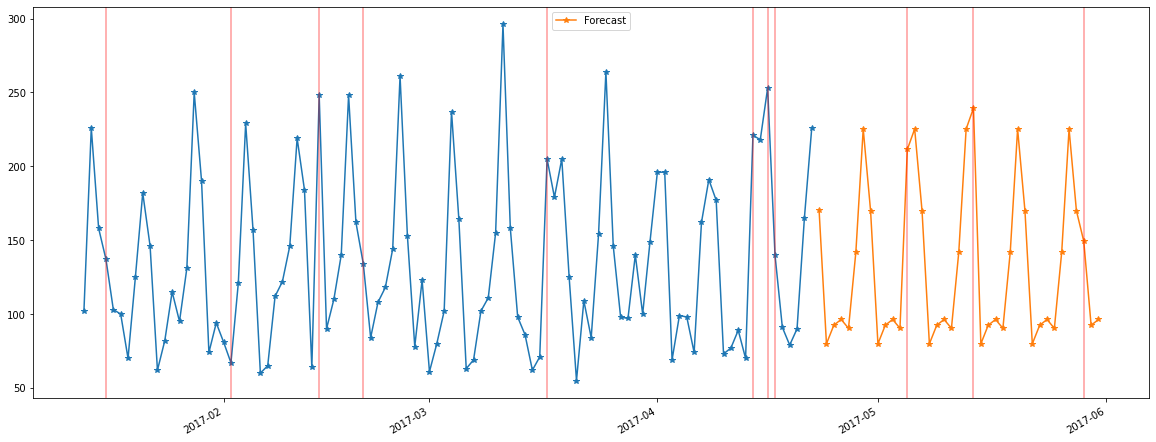

In [ ]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'

# ax = df['total'][-100:].plot(legend=True,figsize=(16,5),title=title, style = '-*')
plt.plot(df[-100:].index, df[-100:].total, '-*')
fcast.plot(legend=True, style = '-*')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df[-100:].query('holiday==1').index:
    plt.axvline(x=x, color='red', alpha = 0.4)

for x in df1[-42:].query('holiday==1').date:
    plt.axvline(x=pd.to_datetime(x), color='red', alpha = 0.4)


Note that as a real forecaster,
- you will have to decide wether the future plot looks correct or not.
- Metrics and other measures aside, it is your responsibility that forecast should be correct.
- Hence forecasting is a game of experience, not just theory and code

# Time Series with Linear Regression


can we use regression for forecasting. Yes because we need to get a value as prediction so its not a classification problem

> we have already seen how regresion is used for prediction in AR Model, so how is this different.
- it is different in the features that we use for regression.
- in AR model we only used past lags till certain degree as features

- if we have some exogenous variables and other data that we can utilize as our feture and covert this to a proper supervised regression problem

## Feature Engineering for Time Series
we will use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature to model.

> **Date-Time Related Features**
Date time features are features created from the time stamp value of each observation. A few examples of these features are the integer hour, month, and day of week for each observation. Data scientists can perform transformations of these date time features using pandas and adding new columns (hour, month, and day of week columns) to their original dataset where hour, month, and day of week information is extracted from the timestamp value for each observation.

- Minutes of the day.
- Hour of day.
- weekend/weekday
- Business hours or not.
- Season of the year.
- Business quarter of the year.
- Dayltime or night.
- Public holiday or not.

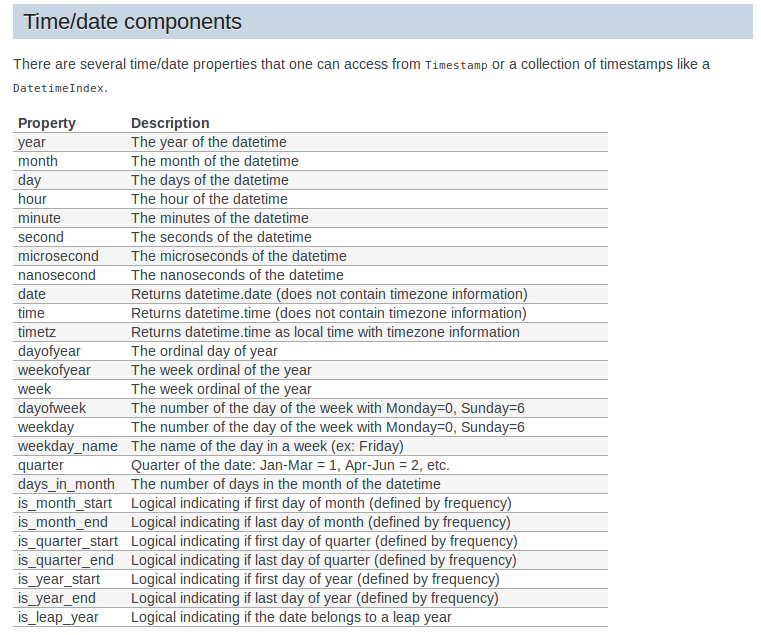

> **Lag Features**
are considered useful because they are created on the assumption that what happened in the past can influence or contain a sort of intrinsic information about the future.
Consider this – you are predicting the stock price for a company. So, the previous day’s stock price is important to make a prediction, right? In other words, the value at time t is greatly affected by the value at time t-1.

- The Pandas library provides the shift() function to help create these shifted or lag features from a time series dataset. Shifting the dataset by 1 creates the t-1 column and so on.
- weekly shift
- monthly shift
- yearly shift

> **Window statistics**
A step beyond adding raw lagged values is to add a summary of the values at previous time steps.
We can calculate summary statistics across the values in the sliding window and include these as features in our dataset.

- Pandas provides a rolling() function that provides rolling window calculations, and it creates a new data structure with the window of values at each timestep.
- getting mean of median of previous window
- Expanding window statistics consist of features that include all previous data. Pandas offers an expanding() function that provides expanding transformations and assembles sets of all prior values for each timestep.

### Implimentation

In [ ]:
df = df1.copy()
df['date'] = pd.to_datetime(df['date'])

We have seen in the decomposed plots that the number of visitors alter during weekdays and weekends and there is also some pattern in the trends over the weeks.

Earlier we saw that the number of visitors was higher on the weekends according to the data.

Therefore let's try engineering a new feature which indicates whether there is a weekend or not.

In [ ]:
df["weekday"] = np.where(((df["weekday"] == "Friday") | (df["weekday"] == "Thursday") | (df["weekday"] == "Wednesday") | (df["weekday"] == "Tuesday") | (df["weekday"] == "Monday")), "working_day", "weekend")
intmdt = pd.get_dummies(df['weekday'])
df = pd.concat([df, intmdt],axis =1 )
df.head()

,date,weekday,holiday,total,weekend,working_day
0,2016-01-01,working_day,1,296.0,0,1
1,2016-01-02,weekend,0,191.0,1,0
2,2016-01-03,weekend,0,202.0,1,0
3,2016-01-04,working_day,0,105.0,0,1
4,2016-01-05,working_day,0,98.0,0,1


**Now lets capture weekly seasonality**

In [ ]:
df['dayofweek'] = df['date'].dt.dayofweek
df['sale_wrt_dow'] = df.groupby('dayofweek')['total'].transform('mean')
df[['sale_wrt_dow', 'dayofweek']].drop_duplicates()

,sale_wrt_dow,dayofweek
31,89.593750,0
32,94.531250,1
33,94.687500,2
34,99.015625,3
35,147.171875,4
36,229.125000,5
37,178.460317,6


Now let's calculate the values of past 1-31 days number of visitors for each observation storing in columns with name Lag_i where i is the previous ith day's observation.

In [ ]:
for i in range(1,32):
  df["Lag_{}".format(i)] = df['total'].shift(i)

Let's try to use the average of past one months values for each observation as a feature named `average_monthly_lag`

In [ ]:
lis = ['Lag_{}'.format(i) for i in range(1,32)]
df.dropna(inplace = True)    # Drop because some Lags will be NaN.
df['last_month_avg_level'] = df.loc[:,lis].sum(axis=1)/31
df.head()

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_23,Lag_24,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level
31,2016-02-01,working_day,0,94.0,0,1,204.0,225.0,150.0,95.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355
32,2016-02-02,working_day,1,100.0,0,1,94.0,204.0,225.0,150.0,...,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226
33,2016-02-03,working_day,0,72.0,0,1,100.0,94.0,204.0,225.0,...,101.0,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742
34,2016-02-04,working_day,0,97.0,0,1,72.0,100.0,94.0,204.0,...,57.0,101.0,212.0,234.0,149.0,69.0,83.0,98.0,105.0,129.774194
35,2016-02-05,working_day,0,147.0,0,1,97.0,72.0,100.0,94.0,...,65.0,57.0,101.0,212.0,234.0,149.0,69.0,83.0,98.0,129.516129


Similarly let's use a feature 'average_weekly_lag' for an average past 7 days observations.



In [ ]:
lis = ['Lag_{}'.format(i) for i in range(1,8)]
df['last_week_avg_level'] = df.loc[:,lis].sum(axis=1)/7
df.head(3)

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_24,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level,last_week_avg_level
31,2016-02-01,working_day,0,94.0,0,1,204.0,225.0,150.0,95.0,...,149.0,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355,135.714286
32,2016-02-02,working_day,1,100.0,0,1,94.0,204.0,225.0,150.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226,135.571429
33,2016-02-03,working_day,0,72.0,0,1,100.0,94.0,204.0,225.0,...,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742,139.000000


We can have 'average_biweekly_lag' as well.

In [ ]:
lis = ["Lag_{}".format(i) for i in range(1,15)]
df['last_2week_avg_level'] = df.loc[:,lis].sum(axis = 1)/14
df.head(3)

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level,last_week_avg_level,last_2week_avg_level
31,2016-02-01,working_day,0,94.0,0,1,204.0,225.0,150.0,95.0,...,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355,135.714286,139.214286
32,2016-02-02,working_day,1,100.0,0,1,94.0,204.0,225.0,150.0,...,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226,135.571429,136.500000
33,2016-02-03,working_day,0,72.0,0,1,100.0,94.0,204.0,225.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742,139.000000,136.500000


In [ ]:
df.shape

(447, 42)

Let's retrieve the present features and columns in the dataframe to decide which featues we can use in predictions.

In [ ]:
df.columns

Index(['date', 'weekday', 'holiday', 'total', 'weekend', 'working_day',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8',
       'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15',
       'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22',
       'Lag_23', 'Lag_24', 'Lag_25', 'Lag_26', 'Lag_27', 'Lag_28', 'Lag_29',
       'Lag_30', 'Lag_31', 'last_month_avg_level', 'last_week_avg_level',
       'last_2week_avg_level', 'dayofweek', 'sale_wrt_dow'],
      dtype='object')

Let's keep a copy of this version of the dataset so that we could use them later.

In [ ]:
import copy             #dfo has the data with all the columns
dfo = df.copy()

In [ ]:
df = dfo.copy()
df = df[['total', 'Lag_1', 'last_month_avg_level', 'last_week_avg_level',
          'last_2week_avg_level', 'sale_wrt_dow', 'holiday']]
df.head()

,total,Lag_1,last_month_avg_level,last_week_avg_level,last_2week_avg_level,sale_wrt_dow,holiday
31,94.0,204.0,143.419355,135.714286,139.214286,89.593750,0
32,100.0,94.0,136.903226,135.571429,136.500000,94.531250,1
33,72.0,100.0,133.967742,139.000000,136.500000,94.687500,0
34,97.0,72.0,129.774194,134.285714,134.000000,99.015625,0
35,147.0,97.0,129.516129,134.571429,133.357143,147.171875,0


Splitting the dataset into train and test.Preparing X and y for training the model.

In [ ]:
train = df.iloc[:df.shape[0]-42].dropna()
test = df.iloc[df.shape[0]-42:]


train_X = train.drop(["total"],axis =1)
train_y = train['total']
test_X = test.drop(["total"],axis =1)
test_y = test['total']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape

# Train and pred
model = LinearRegression()
model.fit(train_X, train_y)
y_pred = pd.Series(model.predict(test_X), index=test.index)
mape(test['total'],y_pred)

0.1550950649148067

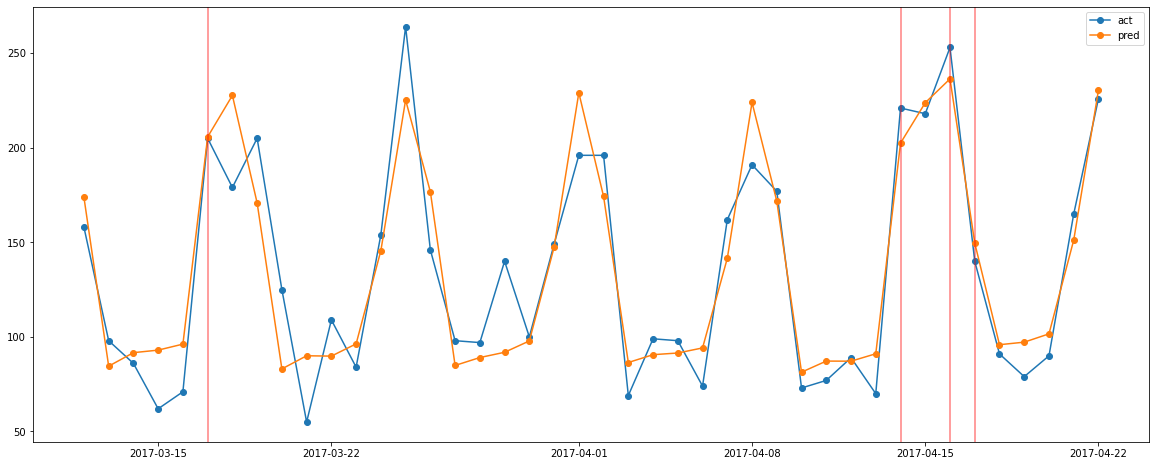

In [ ]:
plt.plot(dfo.tail(42)['date'], test_y, '-o', label='act')
plt.plot(dfo.tail(42)['date'], y_pred, '-o', label='pred')
for x in dfo[-42:].query('holiday==1')['date']:
    plt.axvline(x=x, color='red', alpha = 0.5)
plt.legend()

- This performance is surprisingly very good.
- Note that this is a much simpler algorithm than SARIMAX.

Further improvements can be done with

- Thinking of more inovative features.
- Better feature selection
- Different regressors and Hyper parameter tuning
- Stacking / Cascading etc.

> **IMPORTANT NOTE**
> - please note that SARIMAX forecast was 1 - 42 days into the future. This forecast is only 1 day into the future!! Lag_1 has been used as a feature!
- if your model uses lag or window features it is not possible for multiple predictions is the lags are not available
> - For multiple days ahead forecast you need a **new LR for each horizon**. Shift your target by -k, where k is horizon-1

Let's try to use a combination of newly engineered variables with Lag_1 and weekend to train the linear regression model.

# Facebook’s Prophet

https://peerj.com/preprints/3190.pdf

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets. It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.

> It is particularly good at modeling time series that have multiple seasonalities and doesn’t face some of the above drawbacks of other algorithms. At its core is the sum of three functions of time plus an error term: growth $g(t)$, seasonality $s(t)$, holidays $h(t)$ , and error $e_t$ :

          `y(t)= g(t) + s(t) + h(t) + εt`


- NOTE: Prophet does not perform well on non-stationary data because it is difficult to find the actual seasonality and trend of the data if the patterns are inconsistent.

- Prophet can also handle outliers and handles other data issues by itself.  
- It can fit time-series data having non-linearity in trends as well as holiday effects.
- It works quite well with data having daily, weekly, monthly and/or yearly seasonality
- it can handle multiple seasonalities simultaneously
- It is highly susceptible to missing data, outliers and erratic changes in time-series data.

### Prophet Implementation

For using `prophet` we need to install `pystan` as well which is an interface.

**Instructor Note**:
> - This installation will take around 5-6 mins, so better to do it earlier.

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 63 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.1 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638550 sha256=370c4ffc99c0e6d58b0455307a46ba92846fea8020c282dd122b40907eef2f88
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.4
    Uninstalling cmdstanpy-1.0.4:
      Successfully uninstalled cmdstanpy-1.0.4
ERROR: pip's dependency resolver does not currently take into account all the p

* We're using the same dataset .

* For using Prophet, data set should contain only two columns with column names as ‘ds’ and ‘y’

* ‘ds’ should always be in ‘date-time’ format.

The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations.

In [ ]:
df = df1.copy()

In [ ]:
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total']
df = df[['ds', 'y', 'holiday']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       517 non-null    datetime64[ns]
 1   y        478 non-null    float64       
 2   holiday  517 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 12.2 KB


#### Fitting Prophet

To use Prophet for forecasting, first, a Prophet() object is defined and configured, then it is fit on the dataset by calling the fit() function and passing the data.

The Prophet() object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more. By default, the model will work hard to figure out almost everything automatically.

* `make_future_dataframe` creates a placeholder for storing future variables, so we will be predicting future values for 12 periods.

* Firstly, let's try to fit a model without adding seasonality component and holiday effects.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


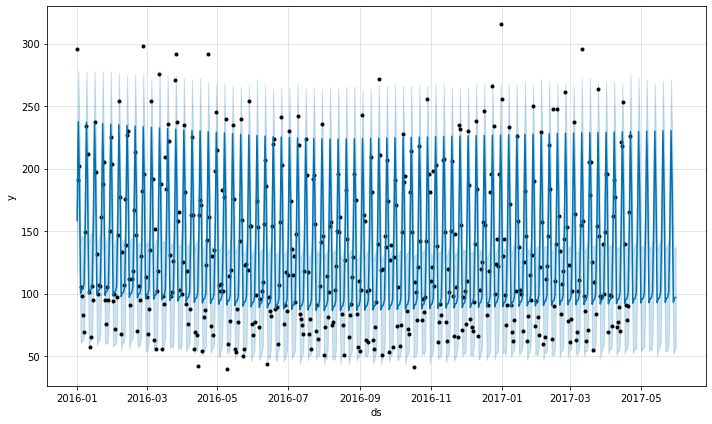

In [ ]:
from fbprophet import Prophet
m = Prophet()
m.fit(df[['ds', 'y']][:-39]) #here we are leaving last 39 observations because we will predict it in 'future'
future = m.make_future_dataframe(periods=39,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

* In the plot, black dots are actual visits, deep blue lines are the predicted visits and light blue lines is the 95% confidence interval around the prediction.

- You can see that the lines are flat and the model is not able to capture the seasonality properly so it is not a good fit.
- Here light blue lines are 95% confidence intervals around the predictions.
- Here we also didn't do anything explicitly for `Nan` values it was handled by `prophet`.

Let's see what has the model stored in `forecast` in the above code snippet.


In [ ]:
forecast.tail(4)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
513,2017-05-28,135.984901,139.960642,223.930192,135.842261,136.133596,46.763259,46.763259,46.763259,46.763259,46.763259,46.763259,0.0,0.0,0.0,182.748160
514,2017-05-29,136.009115,51.728780,137.166510,135.858845,136.166212,-42.860978,-42.860978,-42.860978,-42.860978,-42.860978,-42.860978,0.0,0.0,0.0,93.148137
515,2017-05-30,136.033330,53.952483,135.477332,135.876343,136.198157,-39.697218,-39.697218,-39.697218,-39.697218,-39.697218,-39.697218,0.0,0.0,0.0,96.336112
516,2017-05-31,136.057545,57.143778,138.082433,135.891697,136.229891,-39.106824,-39.106824,-39.106824,-39.106824,-39.106824,-39.106824,0.0,0.0,0.0,96.950721


There are a lot of added features in the dataframe which include `yhat_lower` and `yhat_upper` for the confidence intervals. `yhat` is the prediction.

Comparing the predictions
- Here we are just plotting the observations and predictions of the dates between `2017-01-01` and `2017-04-22`.

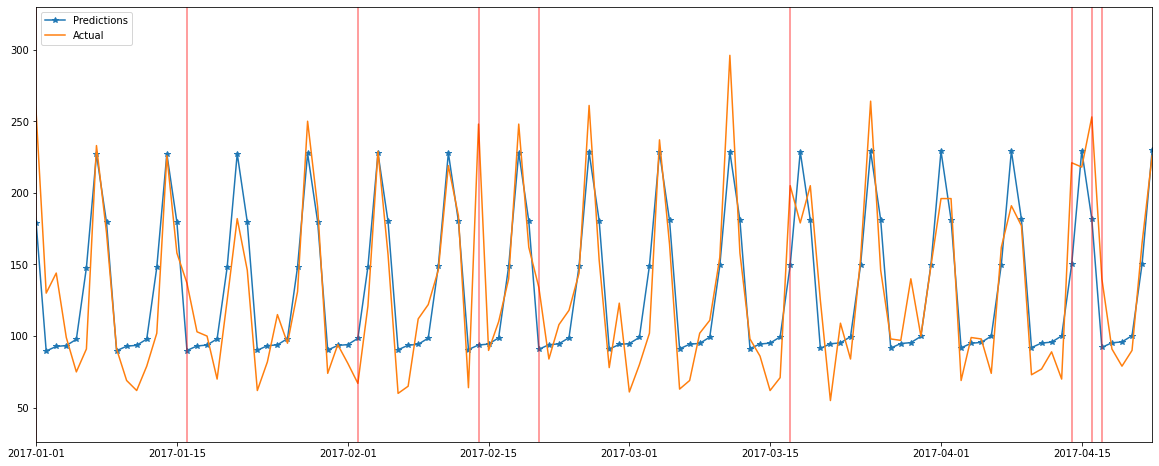

In [ ]:
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']:
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-04-22'))
plt.legend()

- In the plot we can see that the values predicted are flat therefore it's not able to capture the fluctuations properly.

- Here the model is just predicting according to the seasonality it's not taking anything else into account.

- Here the predicted values can be considered as the average seasonality.
  - i.e. The prediction on sunday would be the average of values on past Sundays.

Here we are leaving last 39 observations while calculating the metrics as we don't have actual values of `visitors` for those days.

In [ ]:
performance(df['y'][:-39],forecast['yhat'][:-39])

MAE : 24.059
RMSE : 31.988
MAPE: 0.213


Now, this time, let's apply seasonality(yearly and weekly), and add holiday effects in our model and fit it in order to get a better model.

This can be done simply by setting `yearly_seasonality` and `weekly_seasonality` as `True`.

####**Q. How can we add exogenous variable to the prophet model?**

We can use `add_regressor` for adding features to the prophet model.

<br>

https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

There is another interesting parameter here: `changepoint_prior_scale`
It determines the scale of the change at the time series trend change point.
- By default, changepoint_prior_scale it is set to 0.05, increasing this value allows the automatic detection of more change points and decreases it allows for less. Alternatively, we can specify a number of changepoints to detect using n_changepoints or list the changepoints ourselves using changepoints. Be careful with this, as too many changepoints may cause overfitting.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


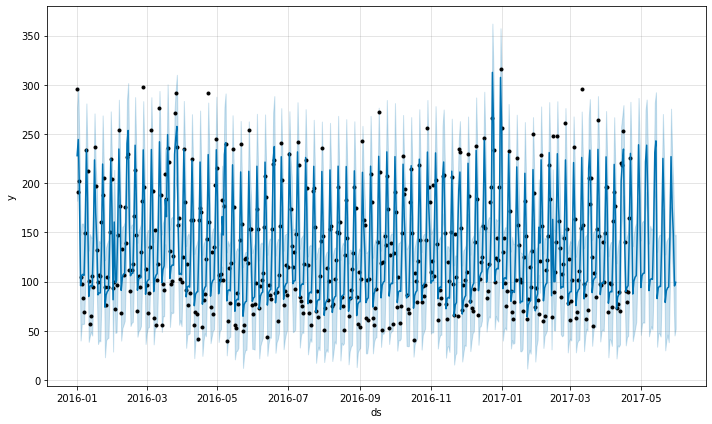

In [ ]:
model2=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,
               changepoint_prior_scale=4)
model2.add_regressor('holiday') #adding holidays data in the model3
model2.fit(df[:-39])
forecast2 = model2.predict(df)
fig = model2.plot(forecast2)

In [ ]:
performance(df['y'][:-39],forecast2['yhat'][:-39])

MAE : 19.921
RMSE : 25.664
MAPE: 0.18


All the metrics have improved from the last model which wasn't using the `holiday` feature.

* We got a Mean absolute percentage error of 18, which might not seem great, but it really depends on the use case.
- The performance has certainly improved in terms of the above mentioned metrics.

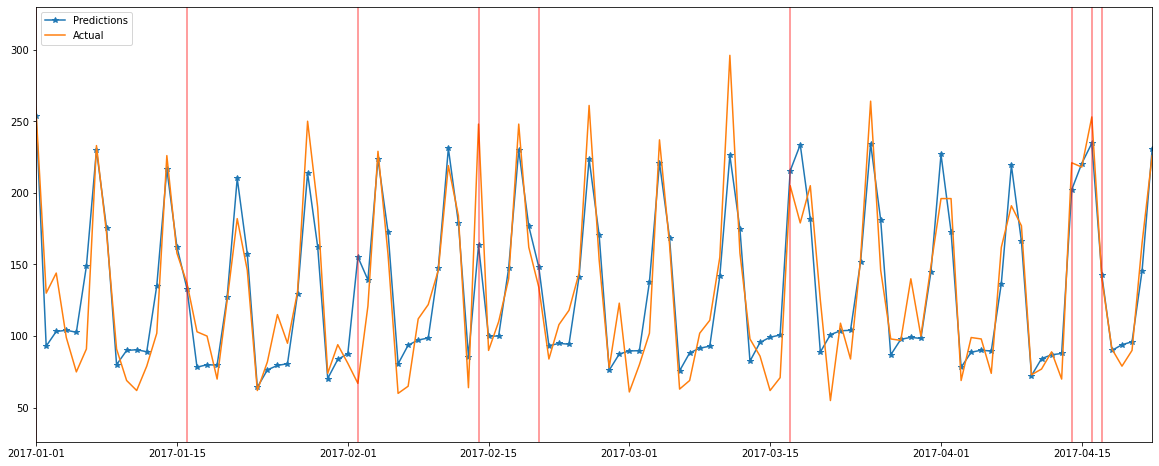

In [ ]:
plt.plot(forecast2['ds'], forecast2['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-04-22'))
for x in df.query('holiday==1')['ds']:
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.legend()

* We can see the model with added yearly and weekly seasonality and holidays, has a good fit trying to capture most of the data points and patterns.



This time the model didn't give flat outputs.

**Even if we don't have the holiday's data, we can use Prophet for getting the holidays data.**
- prophet has holiday list for 19 countries to be directly used

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


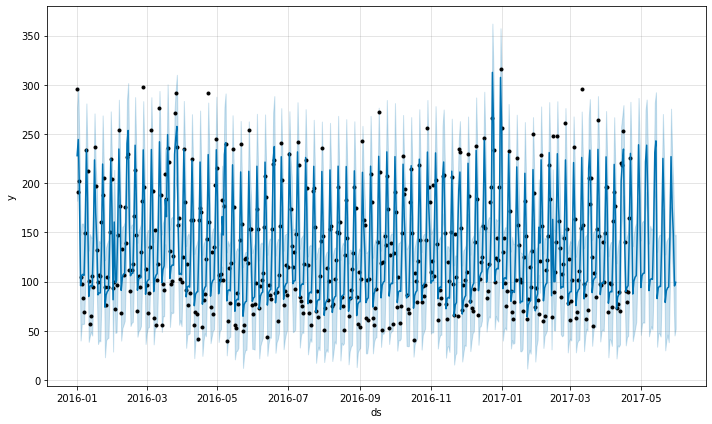

In [ ]:
model3=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,
               changepoint_prior_scale=4)
model3.add_country_holidays(country_name='US') #adding holidays data in the model2
model3.fit(df[:-39])
future = m.make_future_dataframe(periods=39,freq="D")
forecast3 = model3.predict(df)
fig = model3.plot(forecast2)

In [ ]:
performance(df['y'][:-39],forecast3['yhat'][:-39])

MAE : 20.947
RMSE : 27.744
MAPE: 0.185


Here the `MAPE` of predictions has gone down to `18.5`
- This is understandable as the `holiday` data given to us would be more exact or subjective to the region which could be more accountable to the fluctuations, than the general holiday data provided by the model.